# Модель по прогнозированию ухода клиент банка в ближайшее время

**Описание:** Из банка стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых. Предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

**Цель проекта:** Построить модель способную спрогнозировать уйдёт клиент в ближайшее время или нет, с F1-мерой не ниже 0.59. Дополнительно измерить изменение AUC-ROC, сравнивая её значение с F1-мерой.


**План проекта:**
- Загрузит и подготовить данные. 
- Исследовать баланс классов, обучите модель без учёта дисбаланса и написать предварительный вывод.
- Улучшить качество модели, учитывая дисбаланс классов. Описать изменение AUC-ROC. 
- Провести финальное тестирование и достигнуть F1-меры не ниже 0.59. 

**Описание данных:**

**Признаки**
*RowNumber* — индекс строки в данных  
*CustomerId* — уникальный идентификатор клиента  
*Surname* — фамилия  
*CreditScore* — кредитный рейтинг  
*Geography* — страна проживания  
*Gender* — пол  
*Age* — возраст  
*Tenure* — сколько лет человек является клиентом банка  
*Balance* — баланс на счёте  
*NumOfProducts* — количество продуктов банка, используемых клиентом  
*HasCrCard* — наличие кредитной карты  
*IsActiveMember* — активность клиента  
*EstimatedSalary* — предполагаемая зарплата  

**Целевой признак**  
*Exited* — факт ухода клиента



## Подготовка данных

Подключаем нужные нам библиотеки

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.utils import shuffle
from sklearn.metrics import (roc_auc_score, f1_score, precision_score, recall_score)

In [3]:
df = pd.read_csv('/datasets/Churn.csv')

**Посмотрим как выглядет таблица**

In [123]:
df.head(10)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


**Фикcируем размерность** Делаю это перед началом предобработки, чтобы точно знать что ничего не потеряно

In [124]:
df_first = df.shape
df_first

(10000, 14)

**Корректирую названия столбцов (привожу к нижнему регистру)** Делаю это вначале, чтобы не было путаницы с названиями.

In [125]:
df.columns = df.columns.str.lower()

**Проверяю изменения названий столбцов (перевод в нижний регистр) и типы данных.**

In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


**Вывод:** Названия столбцов приведены к нижнему регистру, типы данных присвоены корректно.

**Смотрим пропуски**

In [127]:
df.isna().sum()

rownumber            0
customerid           0
surname              0
creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

In [128]:
df.isna().sum() / df['tenure'].count() * 100 

rownumber          0.0000
customerid         0.0000
surname            0.0000
creditscore        0.0000
geography          0.0000
gender             0.0000
age                0.0000
tenure             9.9989
balance            0.0000
numofproducts      0.0000
hascrcard          0.0000
isactivemember     0.0000
estimatedsalary    0.0000
exited             0.0000
dtype: float64

In [129]:
df['tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

In [130]:
df = df.dropna(subset =['tenure'])

**Вывод:** Пропуски выявлены только в столбце `tenure` - сколько лет человек является клиентом банка.
Объем пропуска составляет примерно 9.99%, восстановить данные или заменить адекватным значением - не представляется возможным, поэтому я их удалю. 

**Проверяем дубликаты; явные и неявыне**

In [131]:
df.duplicated().sum()

0

Неявные дубликаты ищем в столбцах с текстовой информацией, с уникальным числовым индентификатором или с данными имеющими естественные ограничения, типа `age`.

In [132]:
df[df[['customerid', 'surname', 'creditscore', 'geography', 'gender', 'age', 'rownumber', 'tenure']].duplicated(keep=False)]

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited


**Вывод:** Дубликатов нет.

**Проверка аномалий**

*Surname — фамилия.* Фамилии могут быть очень разными, поэтому аномалий нет.

In [133]:
df['surname'].unique()

array(['Hargrave', 'Hill', 'Onio', ..., 'Kashiwagi', 'Aldridge',
       'Burbidge'], dtype=object)

*CreditScore — кредитный рейтинг.* Выборка по клиентам распределена нормально, присутсвует и низкий рейтинг и высокий. 

<AxesSubplot:>

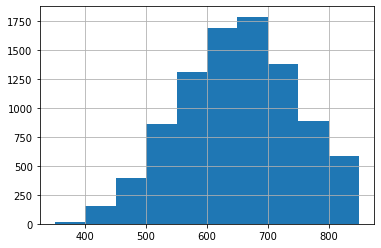

In [134]:
df['creditscore'].hist()

*Geography — страна проживания* Данные представлены по 3 странам: Франция, Испания, Германия. Клиентов из франции примерно в 2 раза больше чем представителей дргуих стран.

<AxesSubplot:>

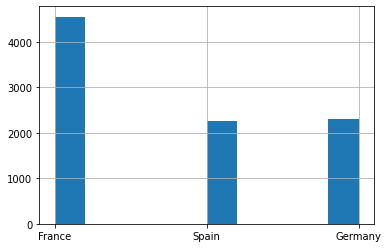

In [135]:
df['geography'].hist()

*Gender — пол.* Пол клиентов отражен верно.

In [136]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

*Age — возраст.* Возраст клиентов соответствует нормальному распределению.

<AxesSubplot:>

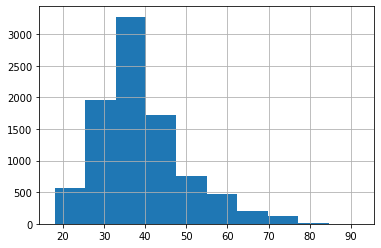

In [137]:
df['age'].hist()

*Tenure — сколько лет человек является клиентом банка*. Распределение данных приближенно к нормальному.

<AxesSubplot:title={'center':'tenure'}, ylabel='Frequency'>

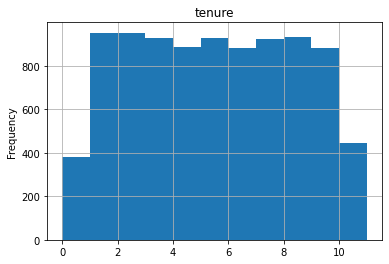

In [138]:
df['tenure'].plot(y = 'tenure', kind = 'hist', range=(0,11), bins = 11, title = 'tenure',grid = True)

*Balance — баланс на счёте.* Согласно данным у 36% клиентов на счету "0", учитывая что примерно половина клиентов из выборки не активны, это вполне может соответствоать действительности. В остальной части данные распределены нормально.

0.00         0.361126
105473.74    0.000220
130170.82    0.000220
104088.59    0.000110
99836.47     0.000110
               ...   
166287.85    0.000110
110929.96    0.000110
131406.56    0.000110
91611.12     0.000110
104001.38    0.000110
Name: balance, Length: 5807, dtype: float64

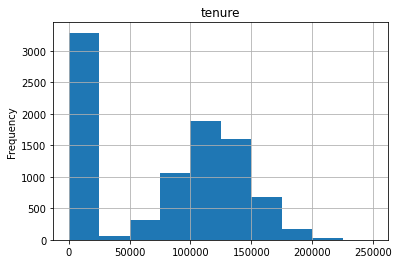

In [139]:
df['balance'].plot(y = 'balance', kind = 'hist', range=(0,250000), bins = 10, title = 'tenure',grid = True)
df['balance'].value_counts(normalize= True)

*NumOfProducts — количество продуктов банка, используемых клиентом.* Большинство клиентов используют 1-2 продукта.

<AxesSubplot:>

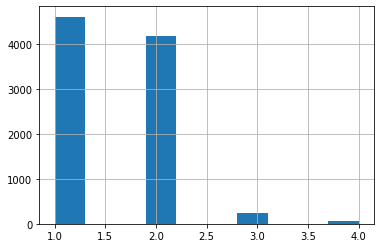

In [140]:
df['numofproducts'].hist()

*HasCrCard — наличие кредитной карты.* У большинтса есть креитная карта.

<AxesSubplot:>

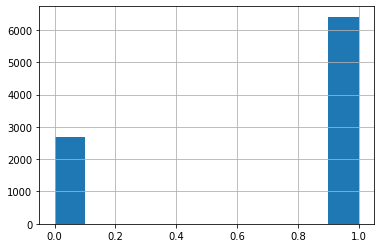

In [141]:
df['hascrcard'].hist()

*IsActiveMember — активность клиента.* Активных и не активных клиентов примерно поровну.

<AxesSubplot:>

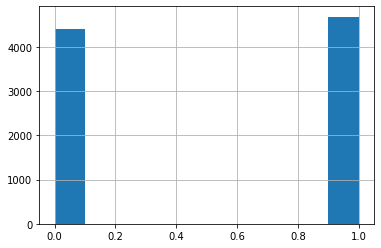

In [142]:
df['isactivemember'].hist()

*EstimatedSalary — предполагаемая зарплата.* Ежемесячный доход у всех клиентов сопоставим. 

<AxesSubplot:>

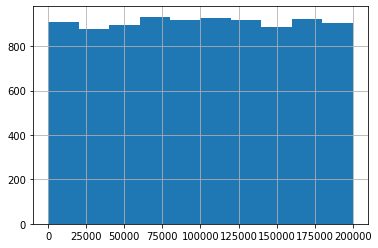

In [143]:
df['estimatedsalary'].hist()

*Exited — факт ухода клиента.* Клиентов которые не ушли из банка гораздо больше. Дисбаланс классов составляет 80% на 20%.

0    0.796062
1    0.203938
Name: exited, dtype: float64

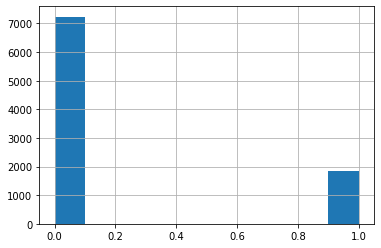

In [144]:
df['exited'].hist()
df['exited'].value_counts(normalize= True)

In [145]:
df_final = df.shape
df_save = df_final[0]/df_first[0] * 100
df_save

90.91

**Вывод раздела предобработки:** Предобработка данных произведена в части приведения названий столбцов к нижнему регистру и удалены пропуски в столбце `tenure`. 
В остальном с данными все в порядке: отсутствуют дубликаты (явные и неявные), типы данных присвоены адекватно, аномалий не выявленно. Данные сохранены в объеме - 90,91%.

***Подготовка признаков***

*Используем прямое кодирование для преобразования категориальных признаков в численные последством OHE.*

In [146]:
df_ohe = pd.get_dummies(df, drop_first=True)

In [4]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [147]:
df_ohe_first = df_ohe.shape
df_ohe_first

(9091, 2800)

Теперь все категориальные признаки переведены в численные, но при этом количетво столбцов значительно выросло, даже при использовании дамми-ловушки.

*Проведем масштабирование признаков*

Для начала произведем разделение датафрейма на признаки и целевой признак, а также на тренировочную, валидационную и тестовые выборки.

In [148]:
target = df_ohe['exited']
features = df_ohe.drop('exited', axis=1)

features_train, features_tv, target_train, target_tv = train_test_split(
    features, target, test_size=0.4, random_state=1234567, stratify= target)

features_test, features_valid, target_test, target_valid = train_test_split(
    features_tv, target_tv, test_size=0.5, random_state=1234567, stratify= target_tv)

numeric = ['rownumber', 'customerid', 'creditscore', 'age', 'tenure', 'balance', 'numofproducts', 'hascrcard', 
           'isactivemember', 'estimatedsalary']

pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

Проверим размерность разделенных выборок.

In [149]:
print(features_train.shape)
print(target_train.shape)

print(features_test.shape)
print(target_test.shape)

print(features_valid.shape)
print(target_valid.shape)

(5454, 2799)
(5454,)
(1818, 2799)
(1818,)
(1819, 2799)
(1819,)


## Исследование задачи

Исследуем баланс классов

In [150]:
print(df['exited'].value_counts())
print(df['exited'].value_counts(normalize= True).round(2))

0    7237
1    1854
Name: exited, dtype: int64
0    0.8
1    0.2
Name: exited, dtype: float64


**Дисбаланс классов составляет 80% на 20%.**

Перед нами стоит задача классификации, а именно построить модель которая спрогнозирует уйдёт клиент из банка в ближайшее время или нет, для решения этой задачи построим следующие модели: дерево решений, случайный лес, логистическая регрессия.
На данном этапе построим модели без учета дисбаланса.

Модель - **Дерево решений**

In [151]:
best_result = 0
best_auc_roc = 0
best_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state=1234567, max_depth=depth)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
            best_auc_roc = auc_roc
            best_result = result
            best_depth = depth
print("F1 - мера:", best_result.round(2))
print("AUC-ROC:", best_auc_roc.round(2))
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth)  

F1 - мера: 0.59
AUC-ROC: 0.82
Количество ветвей наилучшей модели на валидационной выборке: 8


Модель - **Случайный лес**

In [152]:
best_result2 = 0
best_auc_roc2 = 0
best_est2 = 0
best_depth2 = 0
for est in range(10, 101, 10):
    for depth in range(1, 21):
        model2 = RandomForestClassifier(random_state=1234567, n_estimators= est, max_depth=depth) 
        model2.fit(features_train, target_train)
        predicted_valid2 = model2.predict(features_valid)
        probabilities_valid2 = model2.predict_proba(features_valid)
        probabilities_one_valid2 = probabilities_valid2[:, 1]
        auc_roc2 = roc_auc_score(target_valid, probabilities_one_valid2)
        result2 = f1_score(target_valid, predicted_valid2)
        if result2 > best_result2:
            best_auc_roc2 = auc_roc2
            best_result2 = result2
            best_depth2 = depth
            best_est2 = est
print("F1 - мера:", best_result2.round(2))
print("AUC-ROC:", best_auc_roc2.round(2))
print("Количество деревьев наилучшей модели на валидационной выборке:", best_est2)
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth2)  


F1 - мера: 0.11
AUC-ROC: 0.81
Количество деревьев наилучшей модели на валидационной выборке: 10
Количество ветвей наилучшей модели на валидационной выборке: 18


*F1 - мера*  показывает очень низкий результат, нужно проверить полноту и точность по отдельности.

In [153]:
model2 = RandomForestClassifier(random_state=1234567, n_estimators= 10, max_depth=18) 
model2.fit(features_train, target_train)
predicted_valid2 = model2.predict(features_valid)
probabilities_valid2 = model2.predict_proba(features_valid)
probabilities_one_valid2 = probabilities_valid2[:, 1]
auc_roc2 = roc_auc_score(target_valid, probabilities_one_valid2)
result2 = f1_score(target_valid, predicted_valid2)

print("F1 - мера:", result2.round(2))
print("AUC-ROC:", auc_roc2.round(2))
print("Recall:", recall_score(target_valid, predicted_valid2).round(2))
print("Precision:", precision_score(target_valid, predicted_valid2).round(2))


F1 - мера: 0.11
AUC-ROC: 0.81
Recall: 0.06
Precision: 1.0


*F1 - мера* близка к нулю, т.к. полнота близка к "0".

Модель - **Логистическая регрессия**

In [154]:
model3 = LogisticRegression(random_state=1234567, max_iter=1000, solver='liblinear')
model3.fit(features_train, target_train) 
predicted_valid3 = model3.predict(features_valid)
result3 = f1_score(target_valid, predicted_valid)
probabilities_valid3 = model3.predict_proba(features_valid)
probabilities_one_valid3 = probabilities_valid3[:, 1]
auc_roc3 = roc_auc_score(target_valid, probabilities_one_valid3)
print("F1 - мера:", result3.round(2))
print("AUC-ROC:", auc_roc3.round(2))

F1 - мера: 0.59
AUC-ROC: 0.78


**Вывод о работе моделей на выборке с дисбалансом классов:**  
Модель - **Дерево решений** используя 8 ветвей, F1-мера: 0.59, AUC-ROC: 0.82.  
Модель - **Логистическая регрессия** также показала результат F1 - мера: 0.59, AUC-ROC: 0.78 (ниже чем у Дерева решений)  
Модель - **Случайный лес** в данной выборке показала наихудший результат F1 - мера: 0.11, при 10 деревьях с 18 ветвями.
Такое низкое значение метрики связано с тем , что Recall практически равен "0" - 0.06, даже при том что Precision: 1.0.  
AUC-ROC: 0.81, таким образом снижение метрики F1 не отражается на снижении AUC.

**Целевого F1-мера:0.59, достигли модели: Дерево решений и Логистическая регрессия.**

## Борьба с дисбалансом

Для борьбы с дисбалансом, я использую следующие методы: `взвешивание классов`, `upsampling`и `downsampling`.

**Взвешивание классов**: Модель - **Дерево решений**

In [155]:
best_result = 0
best_auc_roc = 0
best_depth = 0
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=1234567, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
            best_auc_roc = auc_roc
            best_result = result
            best_depth = depth
print("F1 - мера:", best_result.round(2))
print("AUC-ROC:", best_auc_roc.round(2))
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth)  

F1 - мера: 0.59
AUC-ROC: 0.85
Количество ветвей наилучшей модели на валидационной выборке: 5


**Взвешивание классов**: Модель - **Случайный лес**

In [156]:
best_result2 = 0
best_auc_roc2 = 0
best_est2 = 0
best_depth2 = 0
for est in range(10, 151, 10):
    for depth in range(1, 21):
        model2 = RandomForestClassifier(random_state=1234567, n_estimators= est, max_depth=depth, class_weight='balanced') 
        model2.fit(features_train, target_train)
        predicted_valid2 = model2.predict(features_valid)
        probabilities_valid2 = model2.predict_proba(features_valid)
        probabilities_one_valid2 = probabilities_valid2[:, 1]
        auc_roc2 = roc_auc_score(target_valid, probabilities_one_valid2)
        result2 = f1_score(target_valid, predicted_valid2)
        if result2 > best_result2:
            best_auc_roc2 = auc_roc2
            best_result2 = result2
            best_depth2 = depth
            best_est2 = est
print("F1 - мера:", best_result2.round(2))
print("AUC-ROC:", best_auc_roc2.round(2))
print("Количество деревьев наилучшей модели на валидационной выборке:", best_est2)
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth2)  

F1 - мера: 0.62
AUC-ROC: 0.86
Количество деревьев наилучшей модели на валидационной выборке: 100
Количество ветвей наилучшей модели на валидационной выборке: 18


**Взвешивание классов**: Модель - **Логистическая регрессия**

In [157]:
model3 = LogisticRegression(random_state=1234567, max_iter=1000, solver='liblinear', class_weight='balanced')
model3.fit(features_train, target_train) 
predicted_valid3 = model3.predict(features_valid)
result3 = f1_score(target_valid, predicted_valid)
probabilities_valid3 = model3.predict_proba(features_valid)
probabilities_one_valid3 = probabilities_valid3[:, 1]
auc_roc3 = roc_auc_score(target_valid, probabilities_one_valid3)
print("F1 - мера:", result3.round(2))
print("AUC-ROC:", auc_roc3.round(2))

F1 - мера: 0.56
AUC-ROC: 0.77


**Вывод о рабооте моделей на выборке со Взвешиванием классов:**  
Модель - **Дерево решений** используя 5 ветвей, F1-мера: 0.59, AUC-ROC: 0.85.  
Модель - **Случайный лес** F1-мера: 0.62, при 100 деревьях с 18 ветвями. AUC-ROC: 0.86.  
Модель - **Логистическая регрессия** F1-мера: 0.56, AUC-ROC: 0.77.  
**Целевого F1-мера: 0.59. достигли модели: Дерево решений и Случайный лес**

**Увеличение выборки**

In [158]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

Техника **upsampling**: Модель - **Дерево решений**

In [159]:
best_result = 0
best_auc_roc = 0
best_depth = 0
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=1234567, max_depth=depth)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
            best_auc_roc = auc_roc
            best_result = result
            best_depth = depth
print("F1 - мера:", best_result.round(2))
print("AUC-ROC:", best_auc_roc.round(2))
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth)  

F1 - мера: 0.59
AUC-ROC: 0.85
Количество ветвей наилучшей модели на валидационной выборке: 5


Техника **upsampling**: Модель - **Случайный лес**

In [160]:
best_result2 = 0
best_auc_roc2 = 0
best_est2 = 0
best_depth2 = 0
for est in range(10, 161, 10):
    for depth in range(1, 11):
        model2 = RandomForestClassifier(random_state=1234567, n_estimators= est, max_depth=depth) 
        model2.fit(features_upsampled, target_upsampled)
        predicted_valid2 = model2.predict(features_valid)
        probabilities_valid2 = model2.predict_proba(features_valid)
        probabilities_one_valid2 = probabilities_valid2[:, 1]
        auc_roc2 = roc_auc_score(target_valid, probabilities_one_valid2)
        result2 = f1_score(target_valid, predicted_valid2)
        if result2 > best_result2:
            best_auc_roc2 = auc_roc2
            best_result2 = result2
            best_depth2 = depth
            best_est2 = est
print("F1 - мера:", best_result2.round(2))
print("AUC-ROC:", best_auc_roc2.round(2))
print("Количество деревьев наилучшей модели на валидационной выборке:", best_est2)
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth2)  

F1 - мера: 0.57
AUC-ROC: 0.84
Количество деревьев наилучшей модели на валидационной выборке: 150
Количество ветвей наилучшей модели на валидационной выборке: 9


Техника **upsampling**: Модель - **Логистическая регрессия**

In [161]:
model3 = LogisticRegression(random_state=1234567, max_iter=1000, solver='liblinear')
model3.fit(features_upsampled, target_upsampled) 
predicted_valid3 = model3.predict(features_valid)
result3 = f1_score(target_valid, predicted_valid)
probabilities_valid3 = model3.predict_proba(features_valid)
probabilities_one_valid3 = probabilities_valid3[:, 1]
auc_roc3 = roc_auc_score(target_valid, probabilities_one_valid3)
print("F1 - мера:", result3.round(2))
print("AUC-ROC:", auc_roc3.round(2))

F1 - мера: 0.57
AUC-ROC: 0.76


**Вывод о рабооте моделей на выборке с Увеличением выборки:**   
Модель - **Дерево решений** используя 5 ветвей, F1-мера: 0.59, AUC-ROC: 0.85.  
Модель - **Случайный лес** F1-мера: 0.57, при 150 деревьях с 9 ветвями. AUC-ROC: 0.84.    
Модель - **Логистическая регрессия** F1-мера: 0.57, AUC-ROC: 0.76.  
**Целевого F1-мера: 0.59. достигла модель: Дерево решений.**


**Уменьшение выборки**

In [162]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

**Техника downsampling:** Модель - **Дерево решений**

In [163]:
best_result = 0
best_auc_roc = 0
best_depth = 0
for depth in range(1, 21):
    model = DecisionTreeClassifier(random_state=1234567, max_depth=depth)
    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    result = f1_score(target_valid, predicted_valid)
    if result > best_result:
            best_auc_roc = auc_roc
            best_result = result
            best_depth = depth
print("F1 - мера:", best_result.round(2))
print("AUC-ROC:", best_auc_roc.round(2))
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth)  

F1 - мера: 0.59
AUC-ROC: 0.85
Количество ветвей наилучшей модели на валидационной выборке: 5


**Техника downsampling:** Модель - **Случайный лес**

In [164]:
best_result2 = 0
best_auc_roc2 = 0
best_est2 = 0
best_depth2 = 0
for est in range(10, 151, 10):
    for depth in range(1, 21):
        model2 = RandomForestClassifier(random_state=1234567, n_estimators= est, max_depth=depth) 
        model2.fit(features_downsampled, target_downsampled)
        predicted_valid2 = model2.predict(features_valid)
        probabilities_valid2 = model2.predict_proba(features_valid)
        probabilities_one_valid2 = probabilities_valid2[:, 1]
        auc_roc2 = roc_auc_score(target_valid, probabilities_one_valid2)
        result2 = f1_score(target_valid, predicted_valid2)
        if result2 > best_result2:
            best_auc_roc2 = auc_roc2
            best_result2 = result2
            best_depth2 = depth
            best_est2 = est
print("F1 - мера:", best_result2.round(2))
print("AUC-ROC:", best_auc_roc2.round(2))
print("Количество деревьев наилучшей модели на валидационной выборке:", best_est2)
print("Количество ветвей наилучшей модели на валидационной выборке:", best_depth2)  

F1 - мера: 0.59
AUC-ROC: 0.85
Количество деревьев наилучшей модели на валидационной выборке: 140
Количество ветвей наилучшей модели на валидационной выборке: 20


**Техника downsampling:** Модель - **Логистическая регрессия**

In [165]:
model3 = LogisticRegression(random_state=1234567, max_iter=1000, solver='liblinear')
model3.fit(features_downsampled, target_downsampled) 
predicted_valid3 = model3.predict(features_valid)
result3 = f1_score(target_valid, predicted_valid)
probabilities_valid3 = model3.predict_proba(features_valid)
probabilities_one_valid3 = probabilities_valid3[:, 1]
auc_roc3 = roc_auc_score(target_valid, probabilities_one_valid3)
print("F1 - мера:", result3.round(2))
print("AUC-ROC:", auc_roc3.round(2))

F1 - мера: 0.55
AUC-ROC: 0.79


**Вывод о рабооте моделей на выборке с Уменьшением выборки:**  
Модель - **Дерево решений** используя 5 ветвей, F1-мера: 0.59, AUC-ROC: 0.85.  
Модель - **Случайный лес** F1-мера: 0.6, при 120 деревьях с 26 ветвями. AUC-ROC: 0.85.   
Модель - **Логистическая регрессия** F1-мера: 0.55, AUC-ROC: 0.79.  
**Целевого F1-мера: 0.59. достигла модель: Дерево решений и Случайный лес**


**ВЫВОД по разделу улучшения моделей:**
По итогу проведенного исследования наилучший показатель F1-меры был достигнут моделью Случайного леса, при взвешивании классов, который составил 0,62. Данную модель я буду использовать для финального тестирования.

Параметр AUC-ROC я измеряла на в каждой модели и можно отметить что AUC показывает более оптимистичную оценку модели поскольку усредняет пороговые значения, в отличии от чем F1-меры, которая является средним гармоническим между Полнотой и Точностью.
Что очень сильно было заметно при расчете метрик Случайного леса где был дисбаланс классов. F1-мера составила 0,11, а AUC при этом был 0,81 что является высоким показателем, но при этом вероятность предсказания положительного класса recall, почти на "0".

## Тестирование модели

Произведем  финальное тестирование модели Случайный лес, при взвешивании классов: количество деревьев - 100, количество ветвей - 18.

In [166]:
model = RandomForestClassifier(random_state=1234567, n_estimators= 100, max_depth=18, max_features=None, class_weight='balanced') 
model.fit(features_train, target_train)

predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)
result = f1_score(target_test, predicted_test)

print("F1-мера:", result.round(2))
print("AUC-ROC:", auc_roc.round(2))

F1-мера: 0.61
AUC-ROC: 0.85


**F1-мера на тестовой выборке равна- 0.61, целевое значение F1-мера:0.59 - достигнуто.**